In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
from statistics import mean
from matplotlib import style
import matplotlib.path as mpath
import pandas as pd

### get SAM iindices

This dataset was downloaded here:
http://www.nerc-bas.ac.uk/public/icd/gjma/newsam.1957.2007.seas.txt

then pre-processed by awk using this command to make it into a csv that can be read into Pandas:

awk 'BEGIN{getline; getline; OFS=","}{print $1, $2, $3, $4, $5, $6}' SAM_indices.txt > SAM_indices.csv

In [2]:
csv_file = '/glade/work/kristenk/SAM_index/SAM_indices.csv'
sam_indices = pd.read_csv(csv_file, header=None)

In [3]:
sam_indices.columns = ['year', 'ANN', 'AUT' , 'WIN', 'SPR', 'SUM']
sam_indices

,year,ANN,AUT,WIN,SPR,SUM
0,1957,-4.24,-2.52,-0.68,-3.55,-2.52
1,1958,-1.27,-2.97,-0.92,1.42,1.12
2,1959,0.47,-0.94,-1.22,3.20,0.31
3,1960,1.52,0.74,0.32,1.00,-0.08
4,1961,1.22,0.48,0.93,0.85,2.19
...,...,...,...,...,...,...
58,2015,4.13,1.43,3.19,1.75,2.19
59,2016,1.67,1.64,1.49,-0.31,-1.75
60,2017,1.67,1.34,1.15,1.42,2.33
61,2018,1.96,-0.81,-0.76,3.92,1.43


#### make it into an Xarray dataset

In [15]:
ann_sam = sam_indices.ANN.values

na = np.newaxis
ts_sam = ann_sam[:,na,na]
ts_sam = xr.DataArray(ts_sam, dims=('time','y','x'))

time_sam = sam_indices.year.values
time_sam = xr.DataArray(time_sam, dims=('time'))

time_sam.isel(time=slice(45,62))

<xarray.DataArray (time: 17)>
array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])
Dimensions without coordinates: time

In [17]:
#just get the satellite period
ts_sam = ts_sam.isel(time=slice(45,62))

### plotting function

In [34]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [36]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4

ds['z_t']=ds_grid.z_t
depths_m=ds_grid.z_t * 0.01
dz=ds_grid.dz
dz_m=ds_grid.dz * 0.01

### Get the satellite chl, must combine these into one netcdf to work with my correlation program

In [7]:
files = sorted(glob(f'/glade/work/kristenk/satellite_data/Chl_annual/A??????????????.L3m_YR_CHL_chlor_a_9km.nc'))       
ds_sat=xr.open_mfdataset(files, decode_times=False,decode_coords=False, concat_dim='time',combine='nested').compute()

In [9]:
ds_sat = ds_sat.drop(['palette'])

In [10]:
ds_sat

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, time: 17)
Coordinates:
  * lat      (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon      (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: time
Data variables:
    chlor_a  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    product_name:                      A20020012002365.L3m_YR_CHL_chlor_a_9km.nc
    instrument:                        MODIS
    title:                             HMODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    temporal_range:                    6-month
    processing_version:                2018.0
    date_created:                      2018-01-09T01:27:43.000Z
    history:                           l3mapgen par=A20020012002365.L3m_YR_CH...
    l2_flag_names:                     ATMFAIL,LAND,HILT,HISATZEN,STRAYLIGHT,...
    time_coverage_start:               2002-07-04T00:40:05.000Z
    time_coverage_end:                 2003-01-01T02:49:59.000Z
    start_orbit_number:                885
    end_orbit_number:                  3522
    map_projection:                    Equidistant Cylindrical
    latitude_units:                    degrees_north
    longitude_units:                   degrees_east
    northernmost_latitude:             90.0
    southernmost_latitude:             -90.0
    westernmost_longitude:             -180.0
    easternmost_longitude:             180.0
    geospatial_lat_max:                90.0
    geospatial_lat_min:                -90.0
    geospatial_lon_max:                180.0
    geospatial_lon_min:                -180.0
    grid_mapping_name:                 latitude_longitude
    latitude_step:                     0.083333336
    longitude_step:                    0.083333336
    sw_point_latitude:                 -89.958336
    sw_point_longitude:                -179.95833
    geospatial_lon_resolution:         9.276625
    geospatial_lat_resolution:         9.276625
    geospatial_lat_units:              degrees_north
    geospatial_lon_units:              degrees_east
    spatialResolution:                 9.28 km
    number_of_lines:                   2160
    number_of_columns:                 4320
    measure:                           Mean
    suggested_image_scaling_minimum:   0.01
    suggested_image_scaling_maximum:   20.0
    suggested_image_scaling_type:      LOG
    suggested_image_scaling_applied:   No
    _lastModified:                     2018-01-09T01:27:43.000Z
    Conventions:                       CF-1.6 ACDD-1.3
    institution:                       NASA Goddard Space Flight Center, Ocea...
    standard_name_vocabulary:          CF Standard Name Table v36
    naming_authority:                  gov.nasa.gsfc.sci.oceandata
    id:                                A20020012002365.L3b_YR_CHL.nc/L3/A2002...
    license:                           http://science.nasa.gov/earth-science/...
    creator_name:                      NASA/GSFC/OBPG
    publisher_name:                    NASA/GSFC/OBPG
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    publisher_email:                   data@oceancolor.gsfc.nasa.gov
    creator_url:                       http://oceandata.sci.gsfc.nasa.gov
    publisher_url:                     http://oceandata.sci.gsfc.nasa.gov
    processing_level:                  L3 Mapped
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/CHL/2018
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         5239829
    data_minimum:                      0.009051356
    data_maximum:                      99.94504

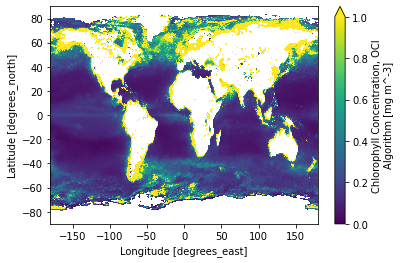

In [11]:
ds_sat.chlor_a.isel(time=10).plot(vmin=0,vmax=1);

In [28]:
%%time
SAM_satCHL_corr = xr.corr(ds_sat.chlor_a, ts_sam, dim='time').squeeze()

CPU times: user 4.13 s, sys: 2.49 s, total: 6.62 s
Wall time: 6.67 s


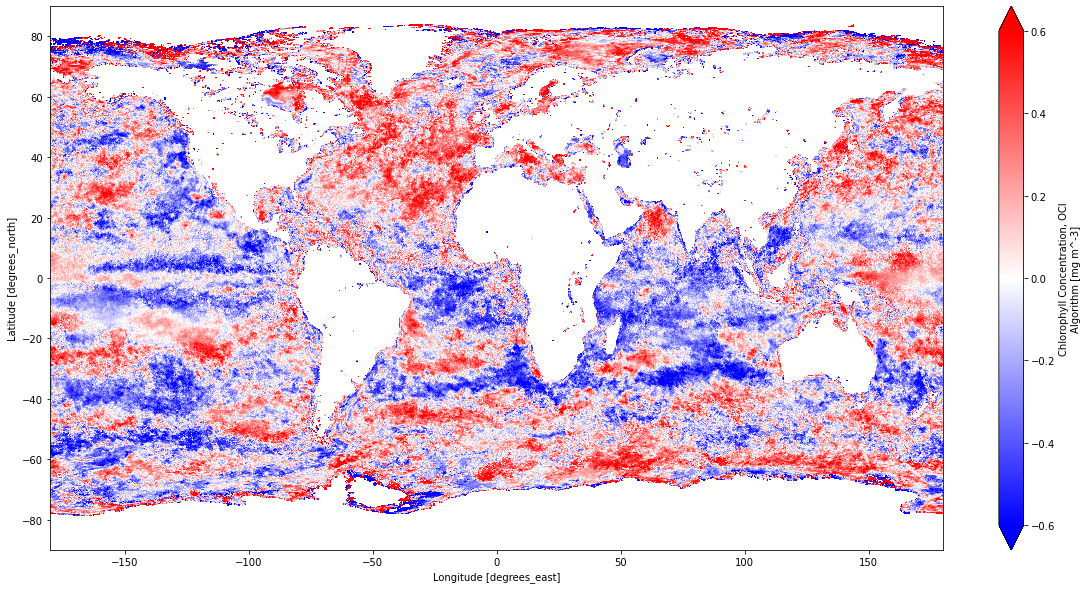

In [29]:
SAM_satCHL_corr.plot(vmin=-0.6,vmax=0.6,cmap='bwr',figsize=(20,10));

### let's just look  in southern ocean

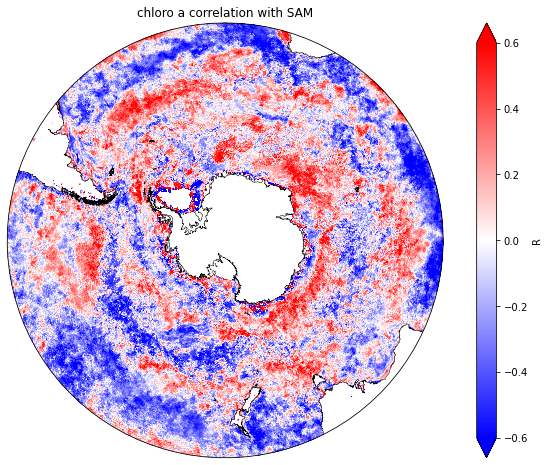

In [30]:
fig = plt.figure(figsize=(12,8))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('chloro a correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_sat.lon, ds_sat.lat, 
                 SAM_satCHL_corr, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#### now get CESM data so I can make a combined figure

In [22]:
variables = ['diatChl', 'coccoChl','spChl','diazChl','diatC', 'coccoC','spC','diazC',
             'zoo1C','zoo2C','zoo3C','zoo4C']
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'

ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004
diatChl
coccoChl
spChl
diazChl
diatC
coccoC
spC
diazC
zoo1C
zoo2C
zoo3C
zoo4C


In [23]:
tmp = ds.spChl + ds.diatChl + ds.diazChl + ds.coccoChl
ds['tot_CHL_surf'] = tmp.isel(z_t_150m=0).squeeze()
ds['tot_CHL_surf'].attrs['long_name']='total chlorophyll at surface'

tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

In [24]:
ds['time']=np.arange(1958,2019,1)
ds.time.isel(time=slice(44,61))

<xarray.DataArray 'time' (time: 17)>
array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018])
Coordinates:
  * time     (time) int64 2002 2003 2004 2005 2006 ... 2014 2015 2016 2017 2018

In [25]:
ds = ds.isel(time=slice(44,61))

In [31]:
%%time
SAM_zoo4C_corr = xr.corr(ds.zoo4C_zint, ts_sam, dim='time').squeeze()

CPU times: user 711 ms, sys: 709 ms, total: 1.42 s
Wall time: 1.58 s


In [32]:
%%time
SAM_CHL_corr = xr.corr(ds.tot_CHL_surf, ts_sam, dim='time').squeeze()

CPU times: user 523 ms, sys: 1.45 s, total: 1.98 s
Wall time: 2.49 s


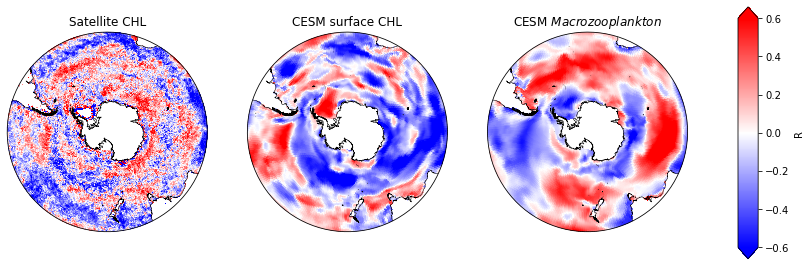

In [42]:
fig = plt.figure(figsize=(14,5))
#----------

ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Satellite CHL')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_sat.lon, ds_sat.lat, 
                 SAM_satCHL_corr, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())



##########################
lon, lat, field = adjust_pop_grid(lons, lats, SAM_CHL_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('CESM surface CHL')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

##########################
lon, lat, field = adjust_pop_grid(lons, lats, SAM_zoo4C_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('CESM ${\it Macrozooplankton}$')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='both', label='R');

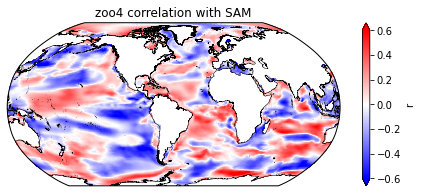

In [26]:
fig = plt.figure(figsize=(8,3))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4 correlation with SAM')
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, ds.zoo4C_zint)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [28]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.diatC_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

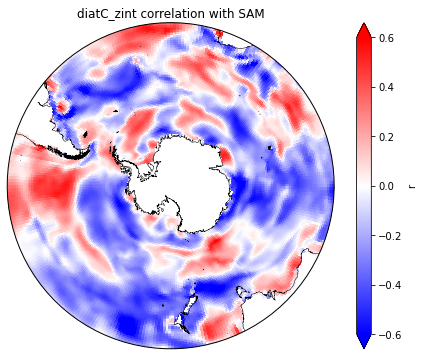

In [29]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [30]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.coccoC_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

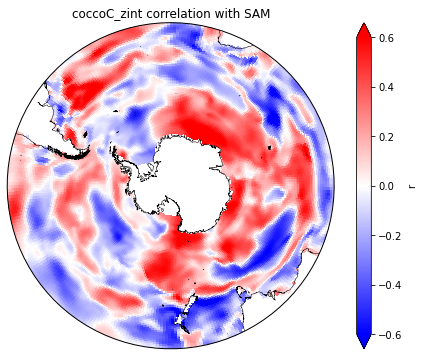

In [31]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('coccoC_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [32]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.phytoC_TOT_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

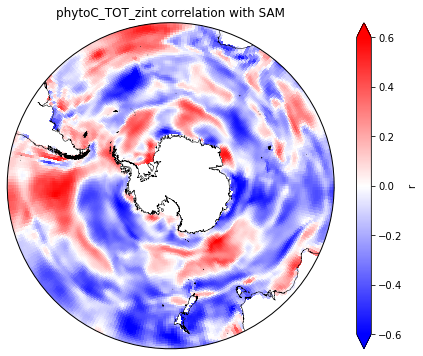

In [33]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('phytoC_TOT_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [34]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.spC_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

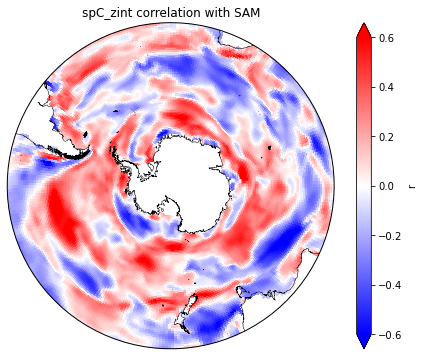

In [35]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('spC_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [36]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.zooC_TOT_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

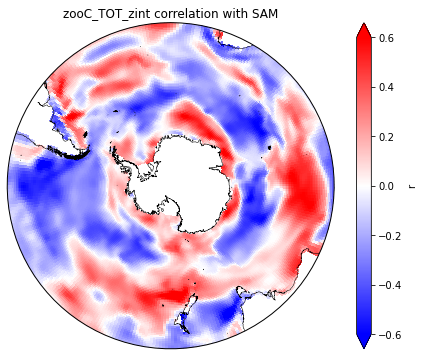

In [37]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zooC_TOT_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [38]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.zoo1C_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

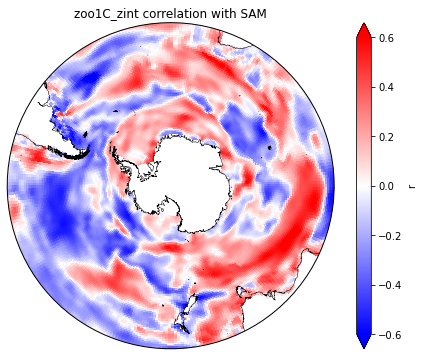

In [39]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1C_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [40]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.zoo2C_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

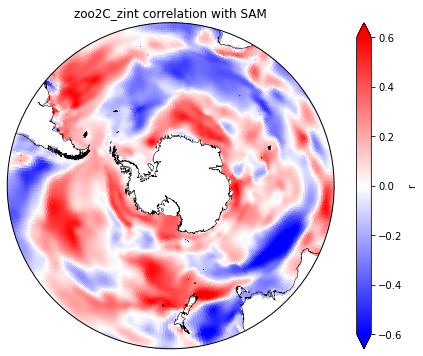

In [41]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo2C_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [42]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.zoo3C_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

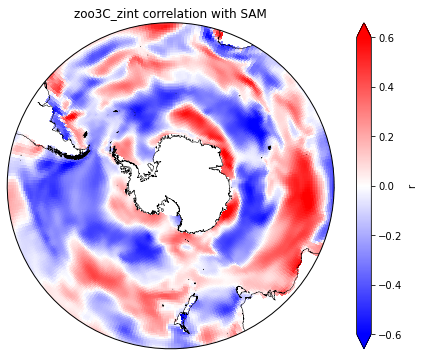

In [43]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3C_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')